In [1]:
import json
from typing import cast
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoTokenizer
from pprint import pprint

/home/jonah/Projects/github.com/JonahSussman/ai-experiments/word2vec/.venv-word2vec/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PAGES = json.load(open("../10k-vital-articles/data/pages.json"))
TOKENIZER = AutoTokenizer.from_pretrained("gpt2")

In [7]:
sequences: list[list[int]] = []
id_to_token: dict[int, str] = {}


for content in [PAGES[i]["wiki_intro"] for i in range(2)]:
# for content in ["Hey hey hey! How's it going?"]:
    batch_encoding = TOKENIZER(content, return_tensors="pt")
    tokens = TOKENIZER.tokenize(content)

    input_ids: list[int] = cast(torch.Tensor, batch_encoding["input_ids"]).flatten().tolist()

    for input_id, token in zip(input_ids, tokens):
        id_to_token[int(input_id)] = token

    sequences.append(input_ids)

print("After converting our words in the corpus into vector of integers:")
print(sequences)

Token indices sequence length is longer than the specified maximum sequence length for this model (1374 > 1024). Running this sequence through the model will result in indexing errors


After converting our words in the corpus into vector of integers:
[[27007, 16438, 6764, 91, 35443, 8876, 290, 3356, 11709, 198, 27007, 6395, 3544, 91, 2025, 9282, 91, 2025, 998, 1042, 357, 6381, 4131, 328, 2288, 14726, 2025, 998, 396, 357, 6381, 4131, 328, 2288, 8, 11709, 198, 27007, 10248, 2708, 11709, 198, 27007, 47, 79, 12, 325, 11632, 12, 521, 891, 11709, 198, 27007, 11041, 3517, 3594, 91, 4475, 28, 17908, 33448, 11709, 198, 27007, 11041, 288, 1820, 9667, 91, 4475, 28, 18517, 48609, 11709, 198, 27007, 11041, 34464, 2366, 17815, 91, 4475, 28, 6747, 1160, 1954, 11709, 198, 27007, 2025, 998, 1042, 40217, 11709, 198, 198, 7061, 6, 2025, 998, 1042, 7061, 6, 318, 257, 16410, 23149, 8876, 11907, 290, 16410, 35443, 3356, 91, 21084, 434, 11907, 326, 12932, 284, 35531, 477, 6712, 326, 43874, 16410, 9800, 414, 60, 4357, 32000, 11, 393, 16410, 20636, 18911, 91, 71, 959, 9282, 60, 4357, 7525, 10822, 262, 16410, 5219, 357, 16104, 414, 14726, 5219, 11907, 290, 16410, 27544, 1042, 60, 4083, 27, 54

In [8]:
# Define parameters
vocab_size = len(TOKENIZER)
embedding_size = 10
window_size = 2

# Generate context-target pairs
contexts = []
targets = []
for seq in sequences:
    # Skip sentences not long enough for the window
    if len(seq) < 2 * window_size + 1:
        continue
    for i in range(window_size, len(seq) - window_size):
        context = seq[i - window_size:i] + seq[i + 1:i + window_size + 1]
        target = seq[i]
        contexts.append(context)
        targets.append(target)

# Convert context and target lists to tensors
X = torch.tensor(contexts, dtype=torch.long)
y = torch.tensor(targets, dtype=torch.long)

# Define the CBOW model in PyTorch
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, x):
        # x has shape (batch_size, context_size)
        embeds = self.embeddings(x)   # (batch, context_size, embedding_size)
        # Average the embeddings from context words
        avg_embeds = torch.mean(embeds, dim=1)
        logits = self.linear(avg_embeds)
        return logits

context_size = 2 * window_size
model = CBOW(vocab_size, embedding_size, context_size)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)  # (batch_size, vocab_size)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    # Optionally print loss occasionally
    # if (epoch + 1) % 20 == 0:
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Extract the embeddings
embeddings = model.embeddings.weight.detach().numpy()

Epoch 1/100, Loss: 10.9096
Epoch 2/100, Loss: 10.3348
Epoch 3/100, Loss: 9.6712
Epoch 4/100, Loss: 8.8484
Epoch 5/100, Loss: 7.8735
Epoch 6/100, Loss: 6.8541
Epoch 7/100, Loss: 5.9787
Epoch 8/100, Loss: 5.3297
Epoch 9/100, Loss: 4.8540
Epoch 10/100, Loss: 4.5134
Epoch 11/100, Loss: 4.2859
Epoch 12/100, Loss: 4.1170
Epoch 13/100, Loss: 3.9536
Epoch 14/100, Loss: 3.7598
Epoch 15/100, Loss: 3.5593
Epoch 16/100, Loss: 3.3692
Epoch 17/100, Loss: 3.1931
Epoch 18/100, Loss: 3.0351
Epoch 19/100, Loss: 2.8920
Epoch 20/100, Loss: 2.7528
Epoch 21/100, Loss: 2.6096
Epoch 22/100, Loss: 2.4657
Epoch 23/100, Loss: 2.3291
Epoch 24/100, Loss: 2.2061
Epoch 25/100, Loss: 2.0962
Epoch 26/100, Loss: 1.9904
Epoch 27/100, Loss: 1.8816
Epoch 28/100, Loss: 1.7745
Epoch 29/100, Loss: 1.6769
Epoch 30/100, Loss: 1.5896
Epoch 31/100, Loss: 1.5073
Epoch 32/100, Loss: 1.4256
Epoch 33/100, Loss: 1.3442
Epoch 34/100, Loss: 1.2661
Epoch 35/100, Loss: 1.1939
Epoch 36/100, Loss: 1.1282
Epoch 37/100, Loss: 1.0669
Epoch 38

In [24]:
%matplotlib inline

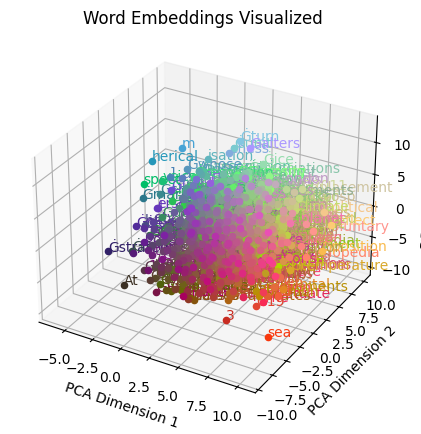

In [25]:
# Perform PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings)

# Compute min and max values for normalization
x_coords = reduced_embeddings[:, 0]
y_coords = reduced_embeddings[:, 1]
z_coords = reduced_embeddings[:, 2]
x_min, x_max = np.min(x_coords), np.max(x_coords)
y_min, y_max = np.min(y_coords), np.max(y_coords)
z_min, z_max = np.min(z_coords), np.max(z_coords)

# Visualize the embeddings (ignore index 0 as it is not assigned to a word)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

for input_id, token in id_to_token.items():
    x_coord, y_coord, z_coord = reduced_embeddings[input_id]
    # Normalize x and y coordinates to the range [0, 1]
    norm_x = (x_coord - x_min) / (x_max - x_min) if (x_max - x_min) != 0 else 0.5
    norm_y = (y_coord - y_min) / (y_max - y_min) if (y_max - y_min) != 0 else 0.5
    norm_z = (z_coord - z_min) / (z_max - z_min) if (z_max - z_min) != 0 else 0.5
    # Use normalized x and y to determine the color (red and green components)
    color = (norm_x, norm_y, norm_z)

    ax.scatter(x_coord, y_coord, z_coord, c=[color])
    ax.text(x_coord, y_coord, z_coord, token, color=color)

ax.set_title("Word Embeddings Visualized")
ax.set_xlabel("PCA Dimension 1")
ax.set_ylabel("PCA Dimension 2")
ax.set_zlabel("PCA Dimension 3")
plt.show()

In [23]:
import plotly.express as px
import pandas as pd

data = {
    'x': [],
    'y': [],
    'z': [],
    'token': [],
}

for input_id, token in id_to_token.items():
    x_coord, y_coord, z_coord = reduced_embeddings[input_id]
    data['x'].append(x_coord)
    data['y'].append(y_coord)
    data['z'].append(z_coord)
    data['token'].append(token)

df = pd.DataFrame(data)

fig = px.scatter_3d(df, x='x', y='y', z='z', text='token', title="Word Embeddings Visualized")
fig.update_traces(textposition='top center')
fig.show()